In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import palettable
import matplotlib.gridspec as gridspec
import os

In [3]:
results_dir = '../../../../results'

In [4]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

In [5]:
clinical_data = pd.read_csv('../../../../data/InVivo/clinical_scores_fixid.tsv', sep='\t', header=[0,1])
challenge_group = pd.Series(clinical_data.iloc[:, 0].values, index=clinical_data.iloc[:, 2].values)
clinical_data.index = clinical_data.iloc[:,2].values
clinical_data = clinical_data.iloc[:,3:]
clinical_data = clinical_data.replace('>9', 10).astype(float)
clinical_data.head()

0                 1                 2                 3  ...    5  \
      Early Middle Late Early Middle Late Early Middle Late Early  ... Late   
NHP01   0.0    NaN  NaN   0.0    NaN  NaN   0.0    NaN  NaN   0.0  ...  8.0   
NHP02   0.0    NaN  NaN   0.0    NaN  NaN   0.0    NaN  NaN   0.0  ...  3.0   
NHP03   0.0    NaN  NaN   0.0    NaN  NaN   0.0    NaN  NaN   0.0  ...  3.0   
NHP04   0.0    NaN  NaN   0.0    NaN  NaN   0.0    NaN  NaN   0.0  ...  3.0   
NHP05   0.0    NaN  NaN   0.0    NaN  NaN   0.0    NaN  NaN   0.0  ...  NaN   

          6                 7                 8              
      Early Middle Late Early Middle Late Early Middle Late  
NHP01  11.0    NaN  NaN   NaN    NaN  NaN   NaN    NaN  NaN  
NHP02   3.0    3.0  8.0  15.0    NaN  NaN   NaN    NaN  NaN  
NHP03   3.0    3.0  3.0   3.0    3.0  3.0   3.0   18.0  NaN  
NHP04   3.0    3.0  3.0   3.0   10.0  NaN   NaN    NaN  NaN  
NHP05   NaN    NaN  NaN   NaN    NaN  NaN   NaN    NaN  NaN  

[5 rows x 27 columns]

In [6]:
viralload = pd.read_csv('../../../../data/InVivo/viral_loads_fixid.tsv', sep='\t', index_col=0)
viralload = viralload.rename(columns={'BL':0})
viralload.head()

,0,1,2,3,4,5,6,7,8
NHP01,UND,NaN,NaN,NaN,NaN,NaN,2.890000e+10,NaN,NaN
NHP02,UND,NaN,NaN,NaN,NaN,NaN,NaN,3.880000e+08,NaN
NHP03,UND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.110000e+09
NHP04,UND,NaN,NaN,NaN,NaN,NaN,NaN,1.460000e+09,NaN
NHP05,UND,NaN,NaN,NaN,NaN,112000000.0,NaN,NaN,NaN


In [7]:
viralload_log = viralload.replace('UND', 1).apply(np.log10)
viralload_log.head()

,0,1,2,3,4,5,6,7,8
NHP01,0.0,NaN,NaN,NaN,NaN,NaN,10.460898,NaN,NaN
NHP02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8.588832,NaN
NHP03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.959518
NHP04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9.164353,NaN
NHP05,0.0,NaN,NaN,NaN,NaN,8.049218,NaN,NaN,NaN


In [8]:
box_height=1.7
box_width=1.7
title_height=.15
left_space = .15
right_space = .85
bottom_space = .13
top_space = .98

In [10]:
viralload_log_unstack = viralload_log.unstack().reset_index()
viralload_log_unstack.columns = ['Day', 'Animal', 'log_viral_load']
viralload_log_unstack = viralload_log_unstack.dropna()
viralload_log_unstack['Day']=viralload_log_unstack['Day'].astype(int)

#vl_perday_mean = viralload_log_unstack.groupby('Day')['log_viral_load'].mean()
#vl_perday_95 = viralload_log_unstack.groupby('Day')['log_viral_load'].quantile(.95)
#vl_perday_5 = viralload_log_unstack.groupby('Day')['log_viral_load'].quantile(.05)

vl_perday_mean = viralload_log_unstack.groupby('Day')['log_viral_load'].median()
vl_perday_95 = viralload_log_unstack.groupby('Day')['log_viral_load'].min()
vl_perday_5 = viralload_log_unstack.groupby('Day')['log_viral_load'].max()


vl_day_sumary_stats = pd.concat([vl_perday_mean, vl_perday_5, vl_perday_95], axis=1)
vl_day_sumary_stats.columns = ['median', 'min', 'max']
vl_day_sumary_stats


,median,min,max
Day,,,
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,5.707529,6.816904,3.296665
4,7.713093,8.568202,6.303196
5,8.536232,9.912753,5.880814
6,9.988542,10.547775,8.557507
7,9.240162,10.222716,8.588832
8,9.522939,9.967080,8.905796


In [11]:
## Full data with all intermediate timepoints within a day
jitter = .1
time_shift = .3


clinical_data_unstack = clinical_data.unstack().reset_index().dropna()
clinical_data_unstack.columns = ['Day', 'Time', 'Animal', 'Clinical_Score']
clinical_data_unstack['Day'] = clinical_data_unstack['Day'].astype(float)
clinical_data_unstack['Day_Shift'] = clinical_data_unstack['Time'].replace({'Early':0, 'Middle':time_shift, 'Late':(time_shift*2)})
clinical_data_unstack['Pos'] = clinical_data_unstack['Day'] + clinical_data_unstack['Day_Shift']

## Per-day summary statistics
#perday_mean = clinical_data_unstack.groupby('Day')['Clinical_Score'].mean()
#perday_95 = clinical_data_unstack.groupby('Day')['Clinical_Score'].quantile(.95)
#perday_5 = clinical_data_unstack.groupby('Day')['Clinical_Score'].quantile(.05)

perday_mean = clinical_data_unstack.groupby('Day')['Clinical_Score'].median()
perday_95 = clinical_data_unstack.groupby('Day')['Clinical_Score'].min()
perday_5 = clinical_data_unstack.groupby('Day')['Clinical_Score'].max()

clinical_day_sumary_stats = pd.concat([perday_mean, perday_5, perday_95], axis=1)
clinical_day_sumary_stats.columns = ['median', 'min', 'max']
clinical_day_sumary_stats

,median,min,max
Day,,,
0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0
4.0,0.0,3.0,0.0
5.0,3.0,13.0,0.0
6.0,3.0,14.0,3.0
7.0,5.0,15.0,3.0
8.0,11.0,18.0,3.0


In [12]:
clinical_data_unstack.head()

,Day,Time,Animal,Clinical_Score,Day_Shift,Pos
0,0.0,Early,NHP01,0.0,0.0,0.0
1,0.0,Early,NHP02,0.0,0.0,0.0
2,0.0,Early,NHP03,0.0,0.0,0.0
3,0.0,Early,NHP04,0.0,0.0,0.0
4,0.0,Early,NHP05,0.0,0.0,0.0


findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


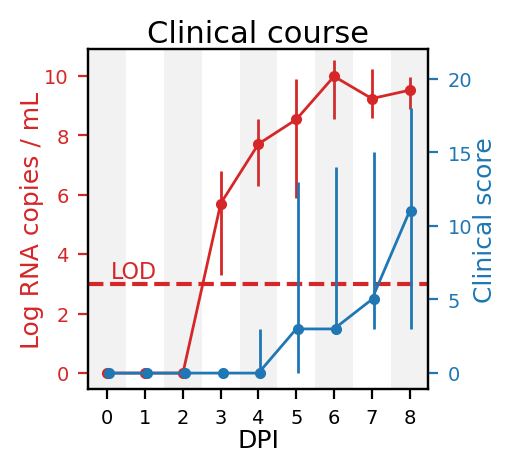

In [14]:
#a_thresh = 1

ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(2, 1, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True)

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[],yticks=[],
          xlim=[0,1],
          ylim=[0,1])

title_ax.text(0.50, 1.0, 'Clinical course', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

color = 'tab:red'
ax.set_ylabel('Log RNA copies / mL', color=color, labelpad=.1)
ax.set_xlabel('DPI', labelpad=0.1)

error = [vl_day_sumary_stats['median'] - vl_day_sumary_stats['min'],
        vl_day_sumary_stats['max'] - vl_day_sumary_stats['median']]

ax.errorbar(x=vl_day_sumary_stats.index, y=vl_day_sumary_stats['median'], 
            yerr=error, 
            fmt='o', ecolor=color, elinewidth=1, markersize=3, color=color, zorder=1)
ax.plot(vl_day_sumary_stats.index, vl_day_sumary_stats['median'], linewidth=1, color=color, zorder=1)
#ax.scatter(viralload_log_unstack.loc[ind, 'Day_jitter'],
#           viralload_log_unstack.loc[ind, 'log_viral_load'],
#           s=3,  color='#901900', zorder=2, edgecolor='None',
#           alpha=.7)

ax.axhline(y=3, color=color, linestyle='--')
ax.annotate('LOD', color=color, xy=(0.1, 3.2), size=8)

ax.tick_params(axis='y', labelcolor=color, colors=color)

color = 'tab:blue'
ax2 = ax.twinx()

error = [clinical_day_sumary_stats['median'] - clinical_day_sumary_stats['min'],
        clinical_day_sumary_stats['max'] - clinical_day_sumary_stats['median']]

ax2.errorbar(x=clinical_day_sumary_stats.index+.05, y=clinical_day_sumary_stats['median'], 
            yerr=error, 
            fmt='o', ecolor=color, elinewidth=1, markersize=3, color=color)

ax2.plot(clinical_day_sumary_stats.index, clinical_day_sumary_stats['median'], linewidth=1, color=color)

#ax2.scatter(df_avg['Day_Jitter'],
#           df_avg.loc[:, 'Clinical_Score'],
#        s=3,  color='#1F4693', zorder=2, edgecolor='None',  alpha=.7)

#ax2.scatter(clinical_data_unstack['Day_Jitter'],
#           clinical_data_unstack.loc[:, 'Clinical_Score'],
#        s=3,  color='#1F4693', zorder=2, edgecolor='None',  alpha=.7)

ax2.tick_params(axis='y', labelcolor=color, colors=color)
ax2.set_ylabel('Clinical score', color=color, labelpad=.1)
ax2.set_ylim([0,22])
ax.set_ylim([-.05*10.9,10.9])
ax2.set_ylim([-.05*22, 22])
ax.set_xlim([-.5, 8.5])
ax.set_xticks(np.arange(0,9))



x_width=1
ylim = [-.05*10.,10.9]
for i in range(9):
  if (i % 2)==0:
    ax.axvspan(i-(x_width/2), i+(x_width/2), ymin=ylim[0], ymax=ylim[1], facecolor='gray', alpha=0.1)



figure_file = os.path.join(results_dir, "Clinical.Timecourse.ViralSymptomsSummary.pdf")
fig.savefig(figure_file)

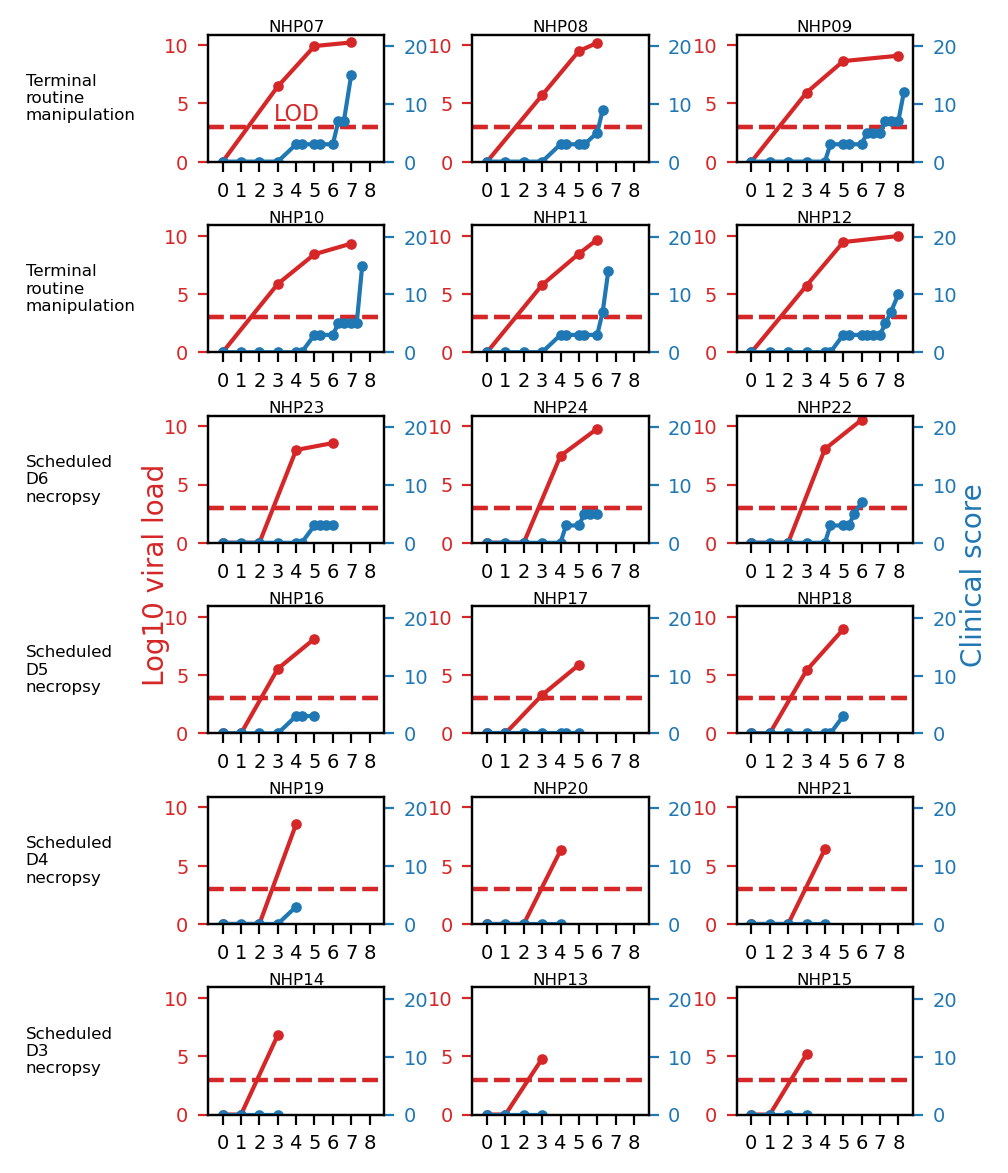

In [16]:
fig = plt.figure(figsize=(5, 6), dpi=200)

full_gs = gridspec.GridSpec(6, 3, fig, left=.01, bottom=.05, right=.95, top=.95,
                       hspace=0.5, wspace=0, width_ratios=[.2,.75, .05])

group_lab_axes = []
for i in range(6):
    ax = fig.add_subplot(full_gs[i, 0], xscale='linear', yscale='linear', frameon=False,
                       xticks=[], yticks=[])
    group_lab_axes.append(ax)




plot_grid = full_gs[:, 1].subgridspec(6, 3, 
                       hspace=0.5, wspace=0.5)

axes = []
for i in range(6):
    row_axes = []
    for j in range(3):
        ax = fig.add_subplot(plot_grid[i, j], xscale='linear', yscale='linear', frameon=True)
        row_axes.append(ax)
    axes.append(row_axes)
axes = np.array(axes).ravel()

ind = ~challenge_group.isin(['Terminal (no manipulations)'])
challenge_group_subset = challenge_group.loc[ind]
challenge_group_subset = challenge_group_subset.sort_values(ascending=False)
animals = challenge_group_subset.index

clinical_color = 'tab:blue'
load_color = 'tab:red'


for (i,a) in enumerate(animals):
    ax2 = axes[i].twinx()
    ind = clinical_data_unstack['Animal']==a
    vdat = clinical_data_unstack.loc[ind,:]

    for j in range(vdat.shape[0]):
        # Plot the last point normally
        # if j != (vdat.shape[0] - 1):
        ax2.scatter(vdat.iloc[j, 5], vdat.iloc[j,3],
                     color=clinical_color, s=8, edgecolor=clinical_color, zorder=1)

    ax2.plot(vdat.iloc[:,5], vdat.iloc[:,3], color=clinical_color, zorder=0)
    ax2.tick_params(axis='y', labelcolor=clinical_color, colors=clinical_color)

    ind = viralload_log_unstack['Animal']==a
    vdat = viralload_log_unstack.loc[ind,:]
    axes[i].plot(vdat.iloc[:, 0], vdat.iloc[:,2],
                    color=load_color, zorder=1) 
    for j in range(vdat.shape[0]):
        # Plot the last point normally
        # if j != (vdat.shape[0] - 1):
        axes[i].scatter(vdat.iloc[j, 0], vdat.iloc[j,2],
                     color=load_color, s=8, edgecolor=load_color, zorder=2)
        axes[i].axhline(y=3, color=load_color, linestyle='--')

    axes[i].tick_params(axis='y', labelcolor=load_color, colors=load_color)
    #axes[i].set_ylabel('Log RNA copies / mL', color=color)

    axes[i].set_xlim([-.8,8.8])
    ax2.set_xlim([-.8,8.8])
    axes[i].set_xticks(np.arange(9))

    ax2.set_ylim([0,22])
    ax2.set_yticks([0, 10, 20])

    axes[i].set_ylim([0,10.9])
    axes[i].set_yticks([0, 5, 10])


    ax2.set_title(a, size=6, pad=-5) # Include the group in the title, or can move this around in Illustrator

# Label only the first LOD
axes[0].annotate('LOD', color=load_color, xy=(2.8, 3.5), size=8)

#challenge_group label
for (i,lab) in enumerate(['Terminal\nroutine\nmanipulation', 'Terminal\nroutine\nmanipulation', 'Scheduled\nD6\nnecropsy', 'Scheduled\nD5\nnecropsy',
            'Scheduled\nD4\nnecropsy', 'Scheduled\nD3\nnecropsy',]):
    group_lab_axes[i].text(0.03, 0.5,lab, va='center', ha='left', fontsize=6)

left_lab_ax = fig.add_subplot(full_gs[1:5, 0], xscale='linear', yscale='linear', frameon=False,
                       xticks=[], yticks=[])
left_lab_ax.text(.8, .5, 'Log10 viral load', rotation=90, color=load_color, fontsize=10, va='center', ha='right')

right_lab_ax = fig.add_subplot(full_gs[1:5, 2], xscale='linear', yscale='linear', frameon=False,
                       xticks=[], yticks=[])
right_lab_ax.text(1., .5, 'Clinical score', rotation=90, color=clinical_color, fontsize=10, va='center', ha='left')

figure_file = os.path.join(results_dir, "Clinical.Timecourse.ViralSymptomsPerAnimal.pdf")
fig.savefig(figure_file)